## Import packages

In [64]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import mlxtend
from mlxtend.plotting import scatterplotmatrix
from mlxtend.plotting import heatmap
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import make_scorer,f1_score, accuracy_score,precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

## Load Dataset

In [41]:
data = pd.read_csv('merge_stock_news.csv')
data.head()

,Date,Positive,Negative,Neutral,Open,Close,Volume,High,Low,Adj Close,Price_change,Tomorrow_price_change
0,2019-01-02,0.105194,0.008503,0.886303,73.260002,76.956497,159662000,77.667999,73.046501,76.956497,NaN,-1.0
1,2019-01-03,0.008750,0.955784,0.035466,76.000504,75.014000,139512000,76.900002,74.855499,75.014000,-1.0,1.0
2,2019-01-04,0.055253,0.022861,0.921886,76.500000,78.769501,183652000,79.699997,75.915497,78.769501,1.0,1.0
3,2019-01-07,0.136375,0.016877,0.846748,80.115501,81.475502,159864000,81.727997,79.459503,81.475502,1.0,1.0
4,2019-01-08,0.036166,0.016844,0.946990,83.234497,82.829002,177628000,83.830498,80.830498,82.829002,1.0,1.0


In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 698 entries, 0 to 697
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Date                   698 non-null    object 
 1   Positive               698 non-null    float64
 2   Negative               698 non-null    float64
 3   Neutral                698 non-null    float64
 4   Open                   698 non-null    float64
 5   Close                  698 non-null    float64
 6   Volume                 698 non-null    int64  
 7   High                   698 non-null    float64
 8   Low                    698 non-null    float64
 9   Adj Close              698 non-null    float64
 10  Price_change           697 non-null    float64
 11  Tomorrow_price_change  697 non-null    float64
dtypes: float64(10), int64(1), object(1)
memory usage: 65.6+ KB


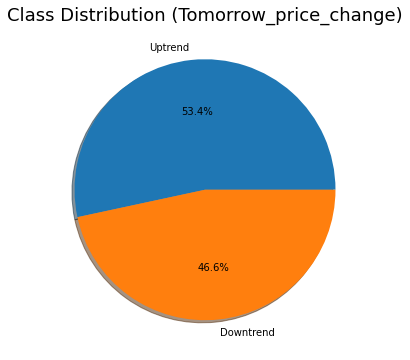

,Positive,Negative,Neutral,Open,Close,Volume,High,Low,Adj Close,Price_change,Tomorrow_price_change
count,698.000000,698.000000,698.000000,698.000000,698.000000,6.980000e+02,698.000000,698.000000,698.000000,697.000000,697.000000
mean,0.215559,0.170496,0.613946,132.359569,132.355255,8.128656e+07,133.788486,130.862810,132.355255,0.076040,0.067432
std,0.181264,0.200950,0.230336,35.890325,35.806238,3.459193e+07,36.305012,35.401733,35.806238,0.997821,0.998440
min,0.008329,0.006506,0.025576,73.260002,75.014000,3.360600e+07,76.900002,73.046501,75.014000,-1.000000,-1.000000
25%,0.074785,0.020499,0.472398,92.584248,92.793499,5.761400e+07,93.585377,91.725122,92.793499,-1.000000,-1.000000
50%,0.156665,0.064352,0.641162,152.202751,151.713753,7.235300e+07,154.155251,149.725502,151.713753,1.000000,1.000000
75%,0.311805,0.284605,0.803182,164.800995,164.699623,9.728150e+07,166.193756,163.177128,164.699623,1.000000,1.000000
max,0.947708,0.963804,0.949012,187.199997,186.570496,3.113460e+08,188.654007,184.839493,186.570496,1.000000,1.000000


In [43]:
#change the type of Date to Datetime
data['Date'] =pd.to_datetime(data.Date)

uptrend = len(data[data['Tomorrow_price_change']==1])
downtrend = len(data[data['Tomorrow_price_change']==-1])

fig, ax = plt.subplots(figsize=(6,6))
plt.pie(x=[uptrend, downtrend], labels=['Uptrend','Downtrend'], shadow=True, autopct='%1.1f%%')
plt.title('Class Distribution (Tomorrow_price_change)', fontsize=18)
plt.show()
data.describe()

## Drop features and add features

In [110]:
#drop features based on EDA (see EDA.ipynb)
cols = ['Date','Tomorrow_price_change','Price_change','Positive', 'Negative', 'Neutral', 'Close', 'High', 'Volume']
df = data[cols]

In [111]:
#drop two rows with Null values
df = df.dropna()
#normalize monetary features
cols = ['Close', 'High', 'Volume']
for col in cols:
    newcol = col + '_normalized'
    df[newcol] = (df[col] - df[col].min())/(df[col].max()-df[col].min())
df.drop(cols,axis=1, inplace=True)
df

,Date,Tomorrow_price_change,Price_change,Positive,Negative,Neutral,Close_normalized,High_normalized,Volume_normalized
1,2019-01-03,1.0,-1.0,0.008750,0.955784,0.035466,0.000000,0.000000,0.381313
2,2019-01-04,1.0,1.0,0.055253,0.022861,0.921886,0.033665,0.025055,0.540239
3,2019-01-07,1.0,1.0,0.136375,0.016877,0.846748,0.057921,0.043202,0.454591
4,2019-01-08,1.0,1.0,0.036166,0.016844,0.946990,0.070054,0.062016,0.518550
5,2019-01-09,-1.0,1.0,0.040182,0.074011,0.885807,0.071327,0.058074,0.336178
...,...,...,...,...,...,...,...,...,...
692,2021-12-23,-1.0,1.0,0.034124,0.325262,0.640614,0.861039,0.850753,0.011457
693,2021-12-27,1.0,-1.0,0.389570,0.208017,0.402413,0.848498,0.859414,0.090307
694,2021-12-28,-1.0,1.0,0.034733,0.030352,0.934915,0.857386,0.852551,0.075725
695,2021-12-29,-1.0,-1.0,0.173104,0.098132,0.728764,0.844299,0.843925,0.007734


In [112]:
# Input features and labels
X = np.array(df[['Positive', 'Negative', 'Neutral']])
y = np.array(df['Tomorrow_price_change'])

# train-test splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,  shuffle=True)
#Evaluation metrics

scoring = {'accuracy' : make_scorer(accuracy_score, greater_is_better=True), 
           'f1_macro' : make_scorer(f1_score, average='macro', greater_is_better=True),
           'precision' : make_scorer(precision_score, zero_division=0),
           'recall' : make_scorer(recall_score, average='macro')  }

## SVM

------------------------------------------------------------------------------------------
Training SVM with kernel {kernel} with cross validation rbf
Mean accs :  0.5431168831168831
Mean f1_macro 0.481400100042511
Mean precision 0.5521303390457601
Mean recall 0.5184598842018197


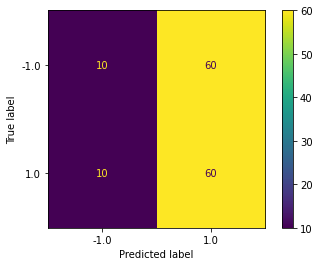

              precision    recall  f1-score   support

        -1.0       0.50      0.29      0.36        70
         1.0       0.50      0.71      0.59        70

    accuracy                           0.50       140
   macro avg       0.50      0.50      0.48       140
weighted avg       0.50      0.50      0.48       140

------------------------------------------------------------------------------------------
Training SVM with kernel {kernel} with cross validation poly
Mean accs :  0.5323376623376624
Mean f1_macro 0.4717254642684475
Mean precision 0.5482916292536677
Mean recall 0.5109131513647643


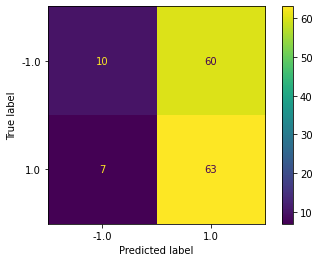

              precision    recall  f1-score   support

        -1.0       0.50      0.29      0.36        70
         1.0       0.50      0.71      0.59        70

    accuracy                           0.50       140
   macro avg       0.50      0.50      0.48       140
weighted avg       0.50      0.50      0.48       140

------------------------------------------------------------------------------------------
Training SVM with kernel {kernel} with cross validation linear
Mean accs :  0.5431818181818182
Mean f1_macro 0.3519757221252575
Mean precision 0.5431818181818182
Mean recall 0.5


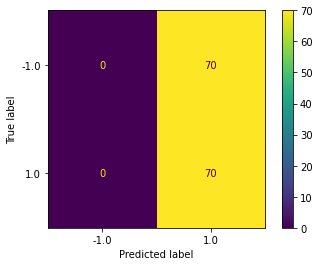

              precision    recall  f1-score   support

        -1.0       0.50      0.29      0.36        70
         1.0       0.50      0.71      0.59        70

    accuracy                           0.50       140
   macro avg       0.50      0.50      0.48       140
weighted avg       0.50      0.50      0.48       140

------------------------------------------------------------------------------------------
Training SVM with kernel {kernel} with cross validation sigmoid
Mean accs :  0.48207792207792205
Mean f1_macro 0.4736632915847327
Mean precision 0.5187700618278522
Mean recall 0.47605955334987593


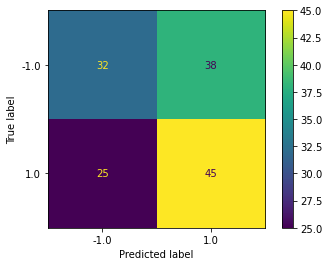

              precision    recall  f1-score   support

        -1.0       0.50      0.29      0.36        70
         1.0       0.50      0.71      0.59        70

    accuracy                           0.50       140
   macro avg       0.50      0.50      0.48       140
weighted avg       0.50      0.50      0.48       140



In [113]:
for kernel in {'linear', 'poly', 'rbf', 'sigmoid'}:
    print("---------"*10)
    print("Training SVM with kernel {kernel} with cross validation", kernel)
    clf = svm.SVC(kernel=kernel)
    clf.fit(X_train, y_train)
    
    # 10 fold cross validation
    cv_scores = cross_validate(clf, X_train, y_train, cv=10, scoring=scoring)
    accs = cv_scores['test_accuracy'].mean()
    print("Mean accs : ",accs)
    f1_macros = cv_scores['test_f1_macro'].mean()
    print("Mean f1_macro", f1_macros)
    prec = cv_scores['test_precision'].mean()
    print("Mean precision", prec)
    recall = cv_scores['test_recall'].mean()
    print("Mean recall", recall)

    # Confusion matrix
    predictions = clf.predict(X_test)
    cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=clf.classes_)
    disp.plot()
    plt.show()
    print(classification_report(y_test, grid_predictions))

## SVM  (kernel  poly) and hyperparameter tuning

In [114]:
clf = svm.SVC(kernel='poly')
param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}
#Adding all values of hyperparameters in a list from which the values of hyperparameter 
#will randomly inserted as hyperparameter
rnd_search_cv = RandomizedSearchCV(clf, param_distributions, n_iter=100, verbose=2, cv=3)
rnd_search_cv.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END ....C=5.113992669947174, gamma=0.020949564259822112; total time=   0.0s
[CV] END ....C=5.113992669947174, gamma=0.020949564259822112; total time=   0.0s
[CV] END ....C=5.113992669947174, gamma=0.020949564259822112; total time=   0.0s
[CV] END ....C=7.879407632944686, gamma=0.011802436643804329; total time=   0.0s
[CV] END ....C=7.879407632944686, gamma=0.011802436643804329; total time=   0.0s
[CV] END ....C=7.879407632944686, gamma=0.011802436643804329; total time=   0.0s
[CV] END ....C=4.27436150521169, gamma=0.0020681259801261383; total time=   0.0s
[CV] END ....C=4.27436150521169, gamma=0.0020681259801261383; total time=   0.0s
[CV] END ....C=4.27436150521169, gamma=0.0020681259801261383; total time=   0.0s
[CV] END ....C=7.238043856912089, gamma=0.020151802570542162; total time=   0.0s
[CV] END ....C=7.238043856912089, gamma=0.020151802570542162; total time=   0.0s
[CV] END ....C=7.238043856912089, gamma=0.0201

[CV] END .....C=7.75381681946029, gamma=0.007674514142704526; total time=   0.0s
[CV] END .....C=7.75381681946029, gamma=0.007674514142704526; total time=   0.0s
[CV] END .....C=7.75381681946029, gamma=0.007674514142704526; total time=   0.0s
[CV] END ...C=5.4792614353869915, gamma=0.008746039843179185; total time=   0.0s
[CV] END ...C=5.4792614353869915, gamma=0.008746039843179185; total time=   0.0s
[CV] END ...C=5.4792614353869915, gamma=0.008746039843179185; total time=   0.0s
[CV] END ....C=5.441509464421177, gamma=0.024554768631277195; total time=   0.0s
[CV] END ....C=5.441509464421177, gamma=0.024554768631277195; total time=   0.0s
[CV] END ....C=5.441509464421177, gamma=0.024554768631277195; total time=   0.0s
[CV] END ...C=6.417384667061026, gamma=0.0011259713310360663; total time=   0.0s
[CV] END ...C=6.417384667061026, gamma=0.0011259713310360663; total time=   0.0s
[CV] END ...C=6.417384667061026, gamma=0.0011259713310360663; total time=   0.0s
[CV] END ...C=5.056643749069

[CV] END ....C=8.223855874454692, gamma=0.011695987356748214; total time=   0.0s
[CV] END ....C=8.223855874454692, gamma=0.011695987356748214; total time=   0.0s
[CV] END ....C=8.223855874454692, gamma=0.011695987356748214; total time=   0.0s
[CV] END ....C=7.8035502655974955, gamma=0.05227667250914842; total time=   0.0s
[CV] END ....C=7.8035502655974955, gamma=0.05227667250914842; total time=   0.0s
[CV] END ....C=7.8035502655974955, gamma=0.05227667250914842; total time=   0.0s
[CV] END ......C=9.40475919996177, gamma=0.01905761355238538; total time=   0.0s
[CV] END ......C=9.40475919996177, gamma=0.01905761355238538; total time=   0.0s
[CV] END ......C=9.40475919996177, gamma=0.01905761355238538; total time=   0.0s
[CV] END ....C=9.868347221258336, gamma=0.004828140610733872; total time=   0.0s
[CV] END ....C=9.868347221258336, gamma=0.004828140610733872; total time=   0.0s
[CV] END ....C=9.868347221258336, gamma=0.004828140610733872; total time=   0.0s
[CV] END .....C=6.4936123846

RandomizedSearchCV(cv=3, estimator=SVC(kernel='poly'), n_iter=100,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f1789255340>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f1788e66af0>},
                   verbose=2)

In [115]:
rnd_search_cv.best_estimator_.fit(X_train, y_train)
rnd_search_cv.best_estimator_.predict(X_test)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1.])

In [116]:


print(f'SVM kernal poly with hyperparameter tuning \n report:\
{classification_report(y_test, rnd_search_cv.best_estimator_.predict(X_test))}')
      


SVM kernal poly with hyperparameter tuning 
 report:              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00        70
         1.0       0.50      1.00      0.67        70

    accuracy                           0.50       140
   macro avg       0.25      0.50      0.33       140
weighted avg       0.25      0.50      0.33       140



/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [117]:
from sklearn.model_selection import GridSearchCV
 
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['poly']}
 
grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3)
 
# fitting the model for grid search
grid.fit(X_train, y_train)
# print best parameter after tuning
print(grid.best_params_)
 
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)
grid_predictions = grid.predict(X_test)
 
# print classification report
print(classification_report(y_test, grid_predictions))

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.545 total time=   0.0s
[CV 2/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.550 total time=   0.0s
[CV 3/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.541 total time=   0.0s
[CV 4/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.541 total time=   0.0s
[CV 5/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.541 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=0.1, kernel=poly;, score=0.545 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=0.1, kernel=poly;, score=0.550 total time=   0.0s
[CV 3/5] END .....C=0.1, gamma=0.1, kernel=poly;, score=0.541 total time=   0.0s
[CV 4/5] END .....C=0.1, gamma=0.1, kernel=poly;, score=0.541 total time=   0.0s
[CV 5/5] END .....C=0.1, gamma=0.1, kernel=poly;, score=0.541 total time=   0.0s
[CV 1/5] END ....C=0.1, gamma=0.01, kernel=poly;, score=0.545 total time=   0.0s
[CV 2/5] END ....C=0.1, gamma=0.01, kernel=poly

[CV 4/5] END ..C=1000, gamma=0.001, kernel=poly;, score=0.541 total time=   0.0s
[CV 5/5] END ..C=1000, gamma=0.001, kernel=poly;, score=0.541 total time=   0.0s
[CV 1/5] END .C=1000, gamma=0.0001, kernel=poly;, score=0.545 total time=   0.0s
[CV 2/5] END .C=1000, gamma=0.0001, kernel=poly;, score=0.550 total time=   0.0s
[CV 3/5] END .C=1000, gamma=0.0001, kernel=poly;, score=0.541 total time=   0.0s
[CV 4/5] END .C=1000, gamma=0.0001, kernel=poly;, score=0.541 total time=   0.0s
[CV 5/5] END .C=1000, gamma=0.0001, kernel=poly;, score=0.541 total time=   0.0s
{'C': 0.1, 'gamma': 1, 'kernel': 'poly'}
SVC(C=0.1, gamma=1, kernel='poly')
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00        70
         1.0       0.50      1.00      0.67        70

    accuracy                           0.50       140
   macro avg       0.25      0.50      0.33       140
weighted avg       0.25      0.50      0.33       140



/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
